# 0. Imports and Settings

In [2]:
%%HTML
<style>
@import url('style.css');
</style>

In [3]:
# Imports
from fredapi import Fred
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import ssl
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import time
import geopandas as gpd

load_dotenv()
API_KEY = os.getenv('API_KEY')
fred = Fred(API_KEY)

<h1> Davide Cossidente </h1>
<h2> Matricola - 166898 </h2>

## 1. Correlazione tra: tasso di interesse ed inflazione

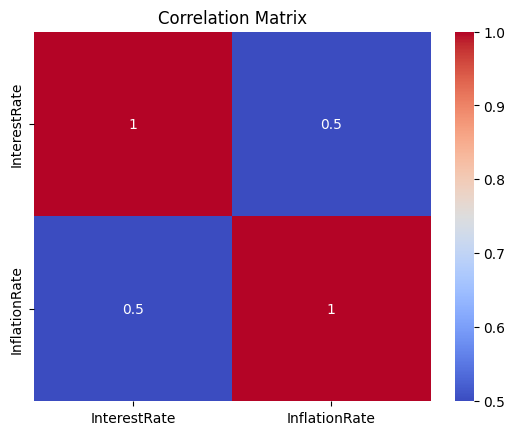

In [4]:
# Retrieving Data
# Interest rate
interestRate = fred.get_series("FEDFUNDS")
# Inflation Rate
inflationRate = fred.get_series("CPIAUCSL")

# Merging Series into a DF
data = pd.DataFrame({
    "InterestRate": interestRate,
    'InflationRate': inflationRate.pct_change() * 100
}).dropna()

# Plotting the correlation matrix into an heatmap
plt.title('Correlation Matrix')
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

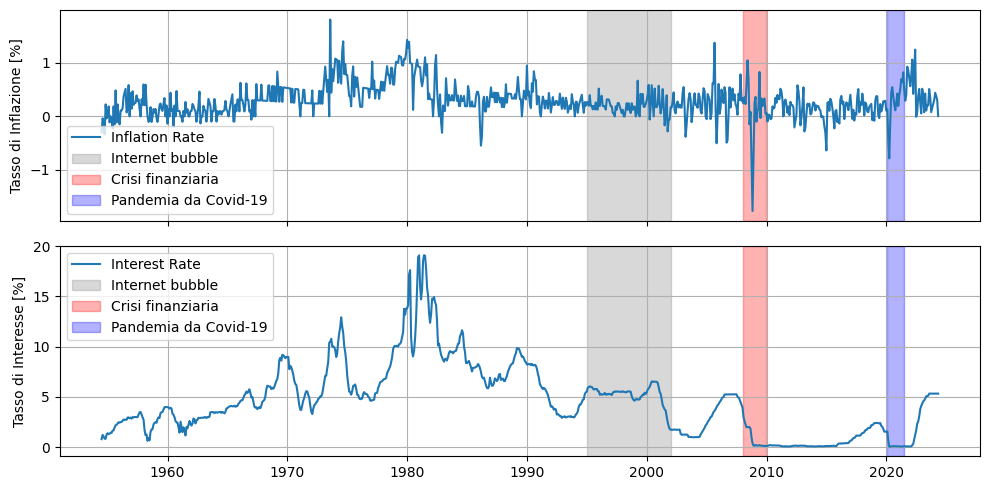

In [5]:
# Visualization of InflationRate and InterestRate change during years
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
# InflationRate plot
ax[0].plot(data.index, data['InflationRate'], label='Inflation Rate')
#ax[0].set_title('Tasso di Inflazione')
ax[0].axvspan('1995-01-01', '2001-12-31', color='grey', alpha=0.3, label='Internet bubble')
ax[0].axvspan('2008-01-01', '2009-12-31', color='red', alpha=0.3, label='Crisi finanziaria')
ax[0].axvspan('2020-02-01', '2021-06-30', color='blue', alpha=0.3, label='Pandemia da Covid-19')
ax[0].set_ylabel("Tasso di Inflazione [%]")
ax[0].grid()
ax[0].legend()

#InterestRate Plot
ax[1].plot(data.index, data['InterestRate'], label='Interest Rate')
#ax[1].set_title('Tasso di Interesse')
ax[1].axvspan('1995-01-01', '2001-12-31', color='grey', alpha=0.3, label='Internet bubble')
ax[1].axvspan('2008-01-01', '2009-12-31', color='red', alpha=0.3, label='Crisi finanziaria')
ax[1].axvspan('2020-02-01', '2021-06-30', color='blue', alpha=0.3, label='Pandemia da Covid-19')
ax[1].legend()
ax[1].set_ylabel("Tasso di Interesse [%]")
ax[1].grid()
plt.tight_layout()
plt.show()

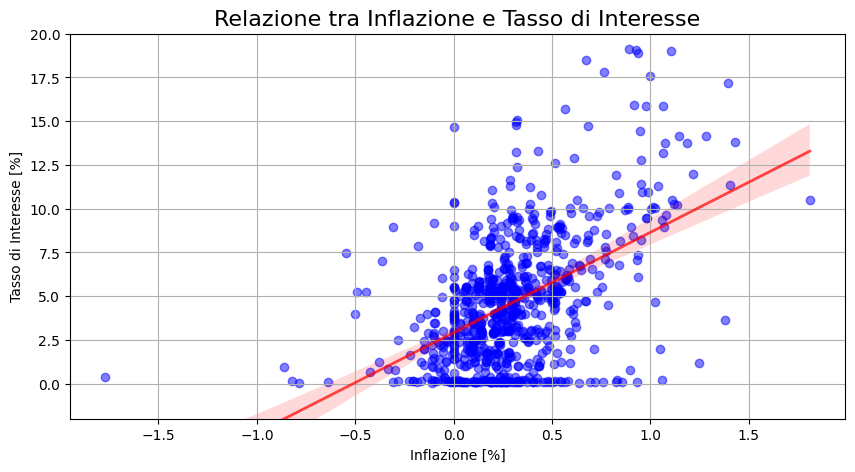

In [6]:

# Grafico di dispersione con linea di regressione
plt.figure(figsize=(10, 5))  # Imposta le dimensioni della figura

# Utilizza seaborn per plottare il grafico di dispersione con la linea di regressione
sns.regplot(x=data['InflationRate'], y=data['InterestRate'], scatter_kws={'alpha':0.5, 'color': "blue"}, line_kws={"color":"red","alpha":0.7,"lw":2})  

# Aggiungi titolo e label agli assi
plt.title('Relazione tra Inflazione e Tasso di Interesse', fontsize=16)
plt.xlabel('Inflazione [%]')
plt.ylabel('Tasso di Interesse [%]')

# Aggiungi una griglia di supporto
plt.grid(True)
plt.ylim([-2,20])
# Mostra il grafico
plt.show()


In [7]:
# Pearson Coefficient between InterestRate and InflationRate
corr, p_value = pearsonr(data['InflationRate'], data['InterestRate'])
print(f'Coefficient di correlazione di Pearson: {corr:.2f}')
print(f'P-value: {p_value:.4f}')

Coefficient di correlazione di Pearson: 0.50
P-value: 0.0000


Coefficiente di correlazione di Pearson: 0.5 <br>
Valore di P: 0.000

## 2. Distribuzione del tasso di disoccupazione per stato

In [8]:
# Retrieving the unemployment rate per state
unrate = fred.search("unemployment state")
unrate_filter = (unrate['seasonal_adjustment_short'] == "SA") & (unrate['frequency'] == 'Monthly') & (unrate['units'] == "Percent") & (unrate['title'].str.startswith("Unemployment Rate in"))
unrate = unrate[unrate_filter]
#unrate.drop(index=["LASMT261982000000003", "LASMT391746000000003"], inplace=True)
unrateSeries = []
for seriesId in unrate.index:
    unrateSeries.append(pd.Series(fred.get_series(seriesId), name=seriesId))
    time.sleep(0.2) # Senza viene bloccata l' api
dfUnrate = pd.concat(unrateSeries, axis=1)

In [36]:
# Getting the states
statesSeriesId = unrate.index
states = unrate['title'].apply(lambda x: str.upper(x.replace("Unemployment Rate in ", ""))).to_list()
statesDf = pd.DataFrame({'State': states}, index=statesSeriesId)

In [37]:
dfUnratePerYear = dfUnrate.reset_index()
dfUnratePerYear['year'] = dfUnratePerYear['index'].dt.year  # Estrai l'anno dalla data
dfUnratePerYear = dfUnratePerYear.drop(columns=["index"]).groupby("year").mean()
unrateStateNameDf = dfUnratePerYear.T.merge(statesDf, left_index=True, right_index=True).set_index("State")


In [53]:
# Retrieving the usa shapefile

usa = gpd.read_file("data/usmap/States_shapefile.shp")
usa['State_Name'] = usa['State_Name'].apply(lambda x: str.upper(x))
usa_data = usa.merge(unrateStateNameDf, left_on='State_Name', right_index=True)


In [61]:
# Interactive plotting of the unemp rate in the U.S.
def plotUSUnrate(year):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    usa_data.plot(column=year, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    ax.axis('off')
    ax.set_title(f'Tasso di disoccupazione nel {year}')


interactive_plot = widgets.interactive(plotUSUnrate, year=widgets.IntSlider(min=1976, max=2024, step=1, value=2024, description='Anno'))
display(interactive_plot)

interactive(children=(IntSlider(value=2024, description='Anno', max=2024, min=1976), Output()), _dom_classes=(…